# ================================================
# Multicollinearity Demonstration Notebook
# ================================================
# This notebook demonstrates:
# 1. What multicollinearity is
# 2. How to generate datasets with low, moderate, and high multicollinearity
# 3. Correlation heatmaps and VIF values
# 4. Effect on regression coefficients (OLS vs Ridge vs Lasso)
# ================================================


# Multicollinearity Demonstration

Multicollinearity occurs when two or more predictor variables are highly correlated, 
leading to redundancy in information. This causes:
- Instability of regression coefficients
- Inflated standard errors
- Difficulty in interpretation

We will:
1. Generate three datasets (low, moderate, high multicollinearity)
2. Visualize correlations with heatmaps
3. Quantify multicollinearity using VIF (Variance Inflation Factor)
4. Compare regression coefficients using OLS, Ridge, and Lasso


In [1]:
# ================================================
# Import libraries
# ================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

np.random.seed(42)
n = 300  # number of samples


## Step 1: Generate datasets

We create three datasets with 5 predictors (X1–X5) and 1 target (y):
- **Low multicollinearity**: predictors are independent
- **Moderate multicollinearity**: some predictors correlated
- **High multicollinearity**: predictors strongly correlated


In [2]:
# ================================================
# 1) Low multicollinearity
# ================================================
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
X3 = np.random.normal(0, 1, n)
X4 = np.random.normal(0, 1, n)
X5 = np.random.normal(0, 1, n)
y1 = 2*X1 - 1.5*X3 + np.random.normal(0, 1, n)
low_df = pd.DataFrame({"X1":X1,"X2":X2,"X3":X3,"X4":X4,"X5":X5,"y":y1})

# ================================================
# 2) Moderate multicollinearity
# ================================================
Z = np.random.normal(0, 1, n)
X1 = Z + np.random.normal(0, 0.5, n)
X2 = Z + np.random.normal(0, 0.5, n)
X3 = np.random.normal(0, 1, n)
X4 = np.random.normal(0, 1, n)
X5 = np.random.normal(0, 1, n)
y2 = 3*X1 - 2*X2 + 1.5*X3 + np.random.normal(0, 1, n)
mod_df = pd.DataFrame({"X1":X1,"X2":X2,"X3":X3,"X4":X4,"X5":X5,"y":y2})

# ================================================
# 3) High multicollinearity
# ================================================
Z = np.random.normal(0, 1, n)
X1 = Z + np.random.normal(0, 0.1, n)
X2 = Z + np.random.normal(0, 0.1, n)
X3 = Z + np.random.normal(0, 0.1, n)
X4 = np.random.normal(0, 1, n)
X5 = np.random.normal(0, 1, n)
y3 = 2*X1 + 2*X2 - 1.5*X3 + np.random.normal(0, 1, n)
high_df = pd.DataFrame({"X1":X1,"X2":X2,"X3":X3,"X4":X4,"X5":X5,"y":y3})


## Step 2: Visualize correlations

We plot heatmaps of the correlation matrices for the three datasets.


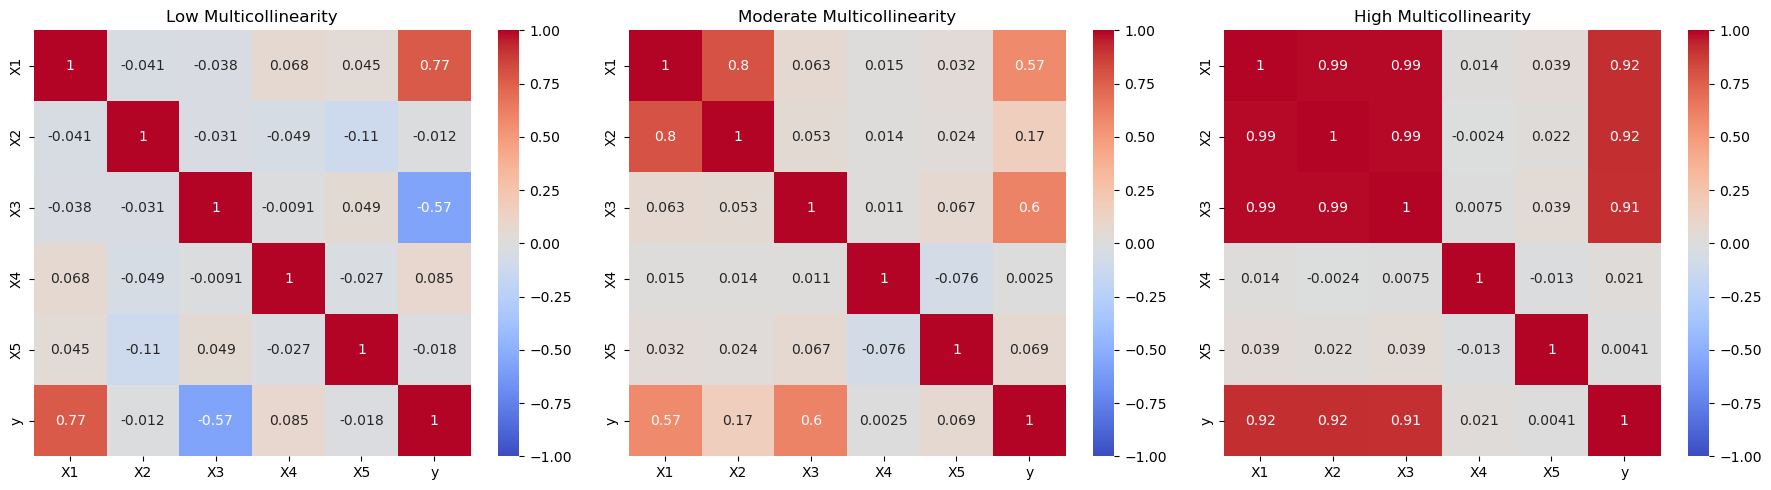

In [3]:
# ================================================
# Plot correlation heatmaps
# ================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(low_df.corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Low Multicollinearity")
sns.heatmap(mod_df.corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Moderate Multicollinearity")
sns.heatmap(high_df.corr(), annot=True, cmap="coolwarm", ax=axes[2], vmin=-1, vmax=1)
axes[2].set_title("High Multicollinearity")
plt.tight_layout()
plt.show()


## Step 3: Variance Inflation Factor (VIF)

VIF is defined as:

$$
\text{VIF}_j = \frac{1}{1 - R_j^2}
$$

where $R_j^2$ is the $R^2$ from regressing predictor $X_j$ on all other predictors.

- VIF ≈ 1: No multicollinearity
- VIF between 1–5: Moderate correlation, usually acceptable
- VIF > 10: Serious multicollinearity problem


In [4]:
# ================================================
# Function to compute VIF
# ================================================
def compute_vif(df, features):
    X = df[features].values
    return pd.DataFrame({
        "Feature": features,
        "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    })

features = ["X1", "X2", "X3", "X4", "X5"]

vif_low = compute_vif(low_df, features)
vif_mod = compute_vif(mod_df, features)
vif_high = compute_vif(high_df, features)

print("Low multicollinearity VIF:\n", vif_low, "\n")
print("Moderate multicollinearity VIF:\n", vif_mod, "\n")
print("High multicollinearity VIF:\n", vif_high, "\n")


Low multicollinearity VIF:
   Feature       VIF
0      X1  1.009412
1      X2  1.018174
2      X3  1.005678
3      X4  1.007593
4      X5  1.018825 

Moderate multicollinearity VIF:
   Feature       VIF
0      X1  2.764588
1      X2  2.760419
2      X3  1.008528
3      X4  1.006737
4      X5  1.011670 

High multicollinearity VIF:
   Feature        VIF
0      X1  71.774356
1      X2  81.781838
2      X3  68.700711
3      X4   1.017398
4      X5   1.024403 



## Step 4: Regression analysis

We compare regression coefficients estimated by:
- **OLS**: Ordinary Least Squares (sensitive to multicollinearity)
- **Ridge**: Shrinks coefficients to stabilize them
- **Lasso**: Shrinks and performs variable selection (sets some to zero)


In [5]:
# ================================================
# Fit OLS, Ridge, Lasso on high multicollinearity dataset
# ================================================
X_high = high_df[features].values
y_high = high_df["y"].values

ols = LinearRegression().fit(X_high, y_high)
ridge = Ridge(alpha=1.0).fit(X_high, y_high)
lasso = Lasso(alpha=0.1).fit(X_high, y_high)

coef_df = pd.DataFrame({
    "Feature": features,
    "OLS": ols.coef_,
    "Ridge": ridge.coef_,
    "Lasso": lasso.coef_
})

coef_df


,Feature,OLS,Ridge,Lasso
0,X1,1.507536,1.368551,0.933531
1,X2,2.120929,1.768263,1.440112
2,X3,-1.173411,-0.680289,0.000000
3,X4,0.051574,0.048534,0.000000
4,X5,-0.050892,-0.056935,-0.000000


## Step 5: Visualize coefficient shrinkage


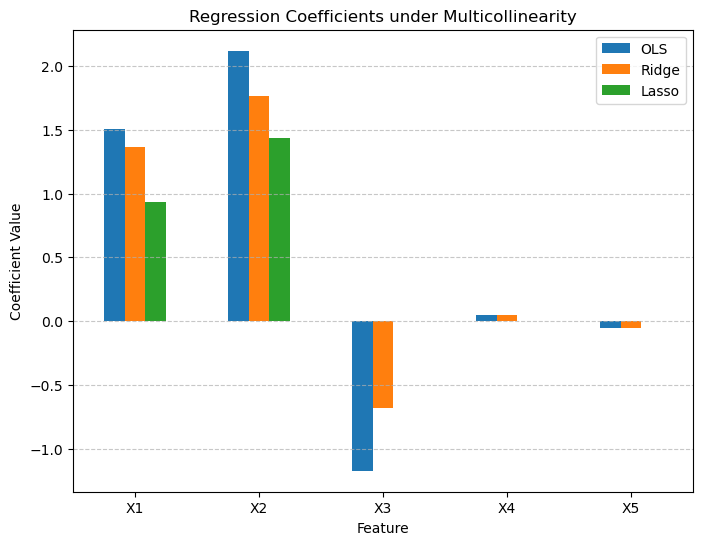

In [6]:
# ================================================
# Plot coefficients for OLS, Ridge, Lasso
# ================================================
coef_plot = coef_df.set_index("Feature")
coef_plot.plot(kind="bar", figsize=(8,6))
plt.title("Regression Coefficients under Multicollinearity")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Key Takeaways

1. **Low multicollinearity**: Predictors independent, VIF ≈ 1.
2. **Moderate multicollinearity**: Some predictors correlated (VIF ≈ 2–3), still acceptable.
3. **High multicollinearity**: Predictors strongly correlated, VIF >> 10, OLS coefficients unstable.
4. **Ridge regression** stabilizes coefficients but keeps all predictors.
5. **Lasso regression** shrinks coefficients and performs variable selection.
